In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import json

import pandas as pd

from divopt.evaluation.process_results import (
    get_sorted_optimizers,
    load_results,
)

In [27]:
runs_base = "../runs/"

results_dict = load_results(runs_base)
limit_names = list(results_dict.keys())
# get task and optimizer lists
results = results_dict["samples"]
tasks = results["Task"].unique()
optimizers = get_sorted_optimizers(results, "samples")

In [28]:
with open("../data/global_settings.json", "r") as f:
    global_settings = json.load(f)
    score_threshold = global_settings["score_threshold"]
    distance_threshold = global_settings["distance_threshold"]
    time_budget = global_settings["time_budget"]
    sample_budget = global_settings["sample_budget"]

In [29]:
from itertools import product
from typing import List

from divopt.evaluation.process_results import compute_diverse_solutions
from divopt.utils import filterdf

n_runs = 3
n_combinations = 3


def get_combinations(n_runs_a: int, n_runs_b, n_combinations: int) -> List[tuple]:
    assert n_runs > 1
    assert n_combinations > 0

    combinations = list(product(range(n_runs_a), range(n_runs_b)))
    combinations = [c for c in combinations if (c[0] != c[1])]

    # sort by difference to use different runs in both i, j
    combinations = sorted(combinations, key=lambda x: abs(x[0] - x[1]))
    combinations = combinations[:n_combinations]
    return combinations


def load_diverse_results(results_dict, optimizer, task, limit_name):
    results = results_dict[limit_name]
    results = filterdf(results, {"Optimizer": optimizer, "Task": task})
    fnames = results["results_fname"]
    fname_diverse = [fname.replace("results", f"results_diverse_all_{limit_name}") for fname in fnames]
    diverse_smiles = []
    for fname in fname_diverse:
        df_diverse = pd.read_csv(fname)
        diverse_smiles.append(df_diverse)
    return diverse_smiles


df_diverse_dict = {}
limit_names = list(results_dict.keys())

args = list(product(limit_names, tasks, optimizers, optimizers))


def compute_combinations(limit_name, task, optimizer_a, optimizer_b):
    # load diverse results, compute limits are already applied in processing results
    results_a = load_diverse_results(results_dict, optimizer_a, task, limit_name)
    results_b = load_diverse_results(results_dict, optimizer_b, task, limit_name)
    combinations = get_combinations(len(results_a), len(results_b), n_combinations)

    combination_results = []
    for i, j in combinations:
        df_diverse_a = results_a[i]
        df_diverse_b = results_b[j]

        diverse_hits_a = len(df_diverse_a)
        diverse_hits_b = len(df_diverse_b)

        if limit_name == "samples":
            df_diverse_a = df_diverse_a[df_diverse_a["unique_idx"] < sample_budget / 2]
            df_diverse_b = df_diverse_b[df_diverse_b["unique_idx"] < sample_budget / 2]
        elif limit_name == "time":
            df_diverse_a = df_diverse_a[df_diverse_a["Total time [s]"] < time_budget / 2]
            df_diverse_b = df_diverse_b[df_diverse_b["Total time [s]"] < time_budget / 2]

        diverse_smiles_a = df_diverse_a["CanSmiles"].to_list()
        diverse_smiles_b = df_diverse_b["CanSmiles"].to_list()

        smiles_combined = diverse_smiles_a + diverse_smiles_b

        diverse_smiles = compute_diverse_solutions(algorithm="maxmin", smiles=smiles_combined, distance_threshold=0.5)
        combination_results.append((diverse_hits_a, diverse_hits_b, len(diverse_smiles)))
    return combination_results

In [30]:
from multiprocessing import Pool

with Pool(8) as pool:
    comb_results = pool.starmap(compute_combinations, args)

In [31]:
all_comb_results = []
for arg_tuple, reslist in zip(args, comb_results):
    for res in reslist:
        all_comb_results.append(arg_tuple + res)

combined_df = pd.DataFrame(
    all_comb_results,
    columns=["limit_name", "task", "optimizer_a", "optimizer_b", "n_diverse_a", "n_diverse_b", "n_diverse_combined"],
)

In [32]:
combined_df["improvement"] = combined_df["n_diverse_combined"] / combined_df[["n_diverse_a", "n_diverse_b"]].max(1)
combined_df["jaccard"] = combined_df["n_diverse_combined"] / combined_df[["n_diverse_a", "n_diverse_b"]].sum(1)

In [33]:
grouped = combined_df.groupby(["limit_name", "task", "optimizer_a", "optimizer_b"]).mean()
grouped.reset_index(inplace=True)

I also did the analysis of inter-method ensembling. For each limit and task I tested ensembles of all pairs of optimizers. 
Both optimizers in the pair got half the compute budget. I then combined the molecules the two optimizers found
and calculate the number of diverse hits. The plots show the improvement of the ensemble over the better optimizer in the pair $\frac{\mu(G_1 \cup G_2)}{\max(\mu(G_1), \mu(G_2))}$. 

Generally the values are less than one, which means that using an ensemble of two optimizers is usually a bad idea.
For the "bad" optimizers ensembling seems to help just like above.



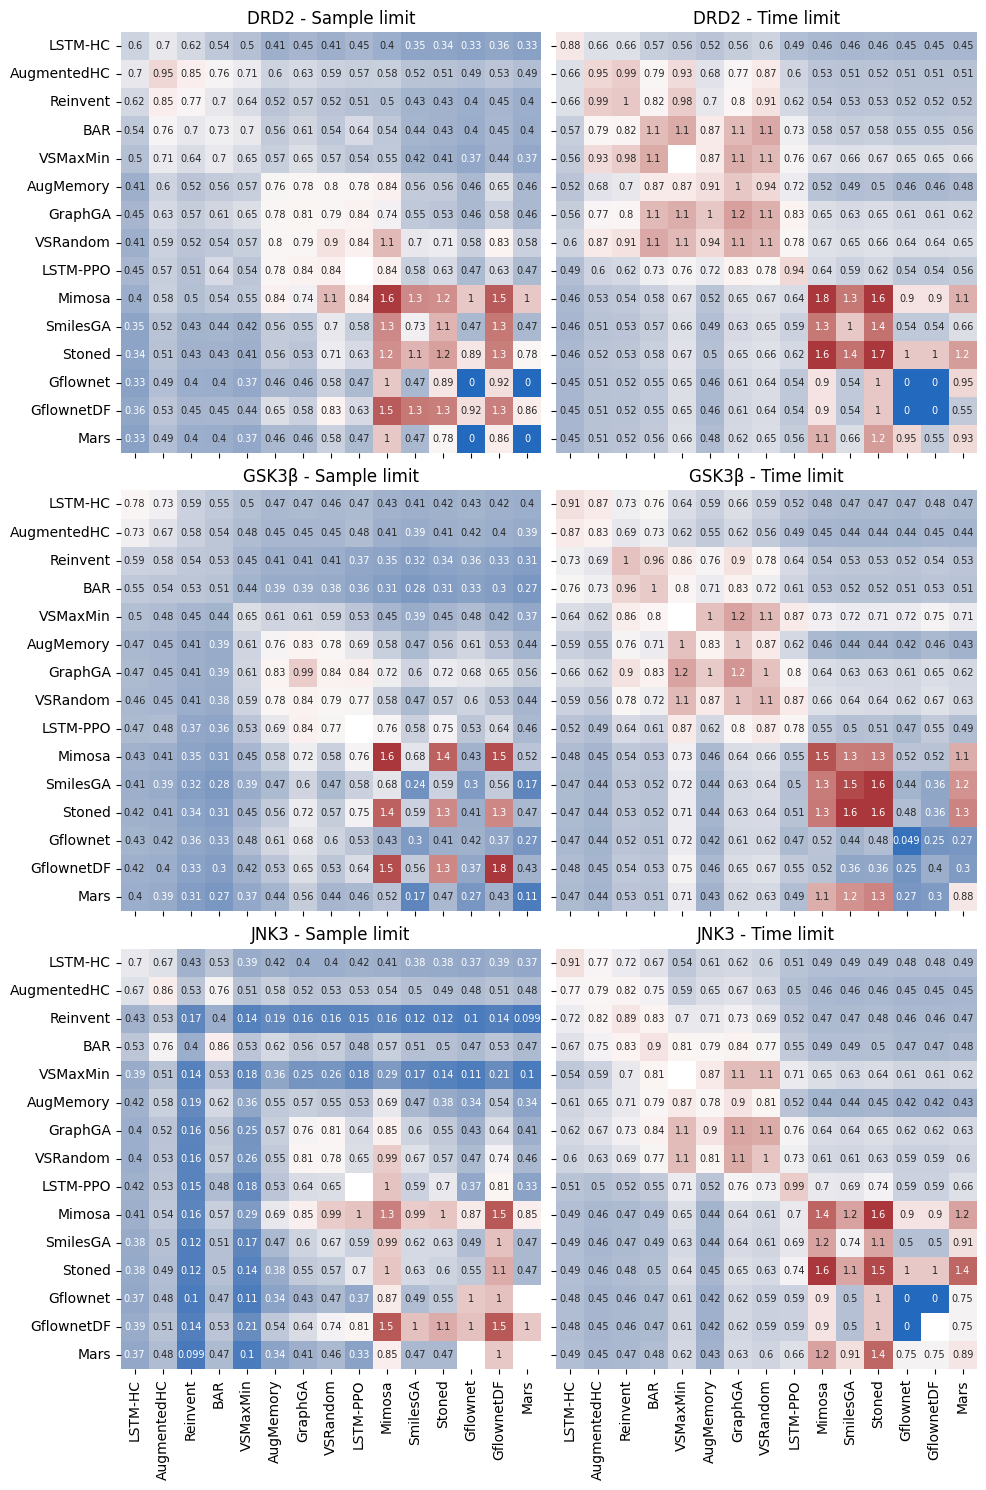

In [34]:
# for each task, limit_name plot a heatmap of the number of diverse solutions
import matplotlib.pyplot as plt
import seaborn as sns

cbars = [False, False, True]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), sharex=True, sharey=True, width_ratios=[1, 1])
for i, limit_name in enumerate(limit_names):
    for j, task in enumerate(tasks):
        optimizers = get_sorted_optimizers(results_dict[limit_name], limit_name)
        df = grouped[(grouped["task"] == task) & (grouped["limit_name"] == limit_name)]

        pivot = df.pivot(columns="optimizer_b", index="optimizer_a", values="improvement")
        pivot = pivot.loc[optimizers, optimizers]
        # make matrix symmetric
        pivot = (pivot + pivot.T) / 2

        ax = axes[j][i]
        sns.heatmap(
            pivot,
            annot=True,
            cmap=sns.color_palette("vlag", as_cmap=True),
            square=True,
            annot_kws={"size": 7},
            ax=ax,
            vmin=0,
            vmax=1.6,
            cbar=False,
            cbar_kws={"shrink": 0.75},
        )
        limit_name_dict = {"samples": "Sample limit", "time": "Time limit"}
        ax.set_title(f"{task} - {limit_name_dict[limit_name]}")
        ax.set_xlabel(None)
        ax.set_ylabel(None)
# reduce space between plots
plt.tight_layout()
# plt.subplots_adjust(wspace=0.0, hspace=0)
plt.savefig("figures/ensemble.pdf")
plt.show()

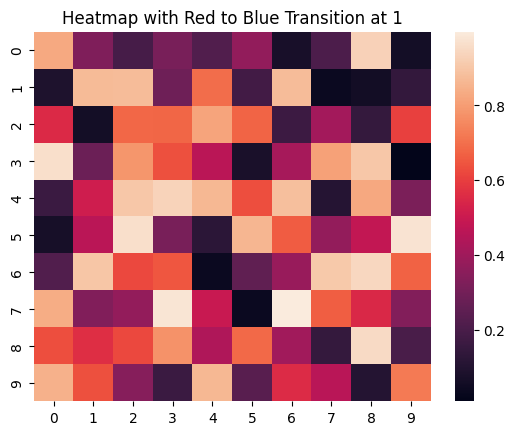

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Define the custom colormap
colors = [(1, 0, 0), (0, 0, 1)]  # Red to Blue
n_bins = 100  # Number of bins for the transition
cmap_name = "custom_red_blue"

custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Create some sample data
data = np.random.rand(10, 10)

# Plot using Seaborn with the custom colormap
sns.heatmap(
    data,
)

plt.title("Heatmap with Red to Blue Transition at 1")
plt.show()